In [1]:
# %% 1
# Package imports
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from pprint import pprint
import copy

categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']

newsgroups_train = fetch_20newsgroups(subset='train',  categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',  categories=categories)

# pprint(newsgroups_train.data[0])

num_train = len(newsgroups_train.data)
num_test  = len(newsgroups_test.data)

vectorizer = TfidfVectorizer(max_features=100)

X = vectorizer.fit_transform( newsgroups_train.data + newsgroups_test.data )
X_train = X[0:num_train, :]
X_test = X[num_train:num_train+num_test,:]

Y_train = newsgroups_train.target
Y_test = newsgroups_test.target


# Normalize the data: subtract the mean image
# mean_image = np.mean(X_train, axis = 0)
# X_train -= mean_image
# X_test -= mean_image

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(2034, 100) (2034,)
(1353, 100) (1353,)


In [2]:
# # Generate a dataset and plot it
# np.random.seed(0)
# X, y = sklearn.datasets.make_moons(1000, noise=0.20)
# print('输入：',X.shape)
# print('输出',y.shape)
# plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

In [3]:
# # Train the logistic regression classifier
# clf = sklearn.linear_model.LogisticRegressionCV()
# clf.fit(X, y)

In [4]:
# # Helper function to plot a decision boundary.
# # If you don't fully understand this function don't worry, it just generates the contour plot below.
# def plot_decision_boundary(pred_func):
#     # Set min and max values and give it some padding
#     x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
#     y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
#     h = 0.01
#     # Generate a grid of points with distance h between them
#     xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
#     # Predict the function value for the whole gid
#     Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
#     Z = Z.reshape(xx.shape)
#     # Plot the contour and training examples
#     plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
#     plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

In [5]:
# # Plot the decision boundary
# plot_decision_boundary(lambda x: clf.predict(x))
# plt.title("Logistic Regression")

### drop out

In [6]:
def dropout(layer_idx,layers, col_size):
    W = layers[layer_idx]['W']
    random_idx = np.random.randint(low = 0, high=W.shape[1] - 1, size=col_size, dtype='l')
    print('random_idx: ',random_idx)
    for i in random_idx:
        W[:,i] = 0
    layers[layer_idx]['W'] = W
    return layers

初始化层

In [7]:
def init_layer(input_dim, output_dim, actFunc):
    np.random.seed(0)
    W = np.random.randn(input_dim, output_dim) / np.sqrt(input_dim)
    b = np.zeros((1,output_dim))
    print('w:',W.shape)
    print('b:',b.shape)
    layer = {'W': W, 'b': b, 'actFunc': actFunc}
    return layer

In [8]:
def init_layers(nn_architecture):
    layers = []
    for l in nn_architecture:
        layer = init_layer(l['input_dim'], l['output_dim'], l['actFunc'])
        layers.append(layer)
    return layers

激活函数

In [9]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)


softmax

In [10]:
def softmax(Z):
    exp_scores = np.exp(Z)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return probs

反向传播

In [11]:
def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1-sig)

def relu_backward(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0
    return dZ

def tanh_backward(dA, Z):
    t = np.tanh(Z)
    res = (1 - t * t)
#     print('res:', res.shape)
#     print('dA:', dA.shape)
    return res * dA

损失函数

In [12]:
def loss(Z, y):
    # 计算损失
    probs = softmax(Z)
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    #在损失上加上正则项（可选）
    # data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

前向传播

In [13]:
def single_layer_forward_prop(X, layer):
    W = layer['W']
#     print(W.shape)
    Z = X.dot(layer['W']) + layer['b']
    if layer['actFunc'] is 'relu':
        actFunction = relu
    elif layer['actFunc'] is 'sigmoid':
        actFunction = sigmoid
    else:
        actFunction = np.tanh
    return actFunction(Z), Z

In [14]:
def full_layers_forward_prop(X, layers):
    memory_forward = []
    Z_out = X
    memo_forward = {
        'Z_out': X
    }
    memory_forward.append(memo_forward)
    layers_now = 0
    for layer in layers:
#         print('forward layers_now:',layers_now)
        Z_out, Z_hide = single_layer_forward_prop(Z_out, layer)
        memo_forward = {
            'Z_out': Z_out,
            'Z_hide': Z_hide
        }
        memory_forward.append(memo_forward)
        layers_now += 1

    # 返回最终的Z_out => actFunc(Z=X*W + b)
    # memory_forward记录每一层的Z_out=actFunc(Z_hide)和Z_hide=W*X+b
#     print('Z_out: ',Z_out.shape)
    return Z_out, memory_forward

反向传播

In [15]:
def single_layer_backward_prop(memo_forward_now, memo_forward_pre, dA_now, layer):
    # 前向神经元个数
    # dA_now为由下一层传回的梯度
    # memo_forward_pre 记录上一层计算结果， Z_hide=X*w+b和Z_out => X_pre
    # memo_forward_now 记录当前层的计算结果，Z_hide => Z_now和Z_out
    X_pre = memo_forward_pre['Z_out']
    Z_now = memo_forward_now['Z_hide']
    back_dim = X_pre.shape[0]

    if layer['actFunc'] is 'sigmoid':
        actFuncBack = sigmoid_backward
    elif layer['actFunc'] is 'relu':
        actFuncBack = relu_backward
    else:
        actFuncBack = tanh_backward

    # 计算当前层外层导数
    # dZ_now = actFunc'(Z_hide)
    dZ_now = actFuncBack(dA_now, Z_now)
    # dW_now = actFunc'(Z_hide) * (X=Z_hide*dW)
#     print('X_pre',X_pre.shape)
#     print('dZ_now',dZ_now.shape)
#     print('dA_now',dA_now.shape)
#     print('Z_now',Z_now.shape)
    dW_now = X_pre.T.dot(dZ_now) / back_dim
    # db_now = actFunc'(Z_hide) * (1=Z_hide*db); 维度转换
    db_now = np.sum(dZ_now, axis=0, keepdims=True) / back_dim
#     print('dW_now:',dW_now.shape)
#     print('db_now',db_now.shape)
    # dA_pre为向前一层传递的梯度；对上一层的Z_out即本层的X求导结果
    # dA_pre = actFunc'(Z_hide) * (W=Z_hide*dX)
    W_now = copy.deepcopy(layer['W'])
    dA_pre = dZ_now.dot(W_now.T)
#     print('dA_pre',dA_pre.shape)
    
    return dA_pre,dW_now, db_now

In [16]:
def full_layers_backward_prop(Z_out, memory_forward, layers, X, y):
#     Z_out, memo_forward = full_layers_forward_prop(X, layers)
    # 反向传播
    probs = softmax(Z_out)
    probs[range(num_examples), y] -= 1
    dA_pre = probs
#     print('dA_now:', dA_now.shape)
#     print('probs:', probs.shape)
    memory_backward = []
    layers.reverse()
    memory_forward.reverse()

    length = len(layers)
    for idx in range(length):
#         print('layer_now:', idx)
        dA_pre, dW_now, db_now = single_layer_backward_prop(memory_forward[idx],memory_forward[idx+1],dA_pre,layers[idx])
        memo_backward = {
            'dW_now': dW_now,
            'db_now': db_now
        }
        memory_backward.append(memo_backward)

    return memory_backward

更新网络

In [17]:
def update(layers, memory_backward):
#     print('layers: ',len(layers)
#     print('memory_backward: ', len(memory_backward))
    length = len(layers)
#     print(memory_backward)
#     print(layers)
#     print(memory_backward)
    for idx in range(length):
        dW = memory_backward[idx]['dW_now']
#         print('dW.shape: ', dW.shape)
        layers[idx]['W'] -= epsilon * memory_backward[idx]['dW_now']
        layers[idx]['b'] -= epsilon * memory_backward[idx]['db_now']
        
#     print(memory_backward)
#     print(layers)
    return layers

预测函数

In [18]:
def predict(X, layers):
    Z_out, memory_forward = full_layers_forward_prop(X,layers)
    probs = softmax(Z_out)
    return np.argmax(probs, axis=1)

计算准确率

In [19]:
def get_acc(X, layers):
    Z_out, memory_forward = full_layers_forward_prop(X,layers)
    probs = softmax(Z_out)
#     print(probs)
#     return np.argmax(probs, axis=1)
    acc = np.mean(Y_test==np.argmax(probs, axis=1))
    return acc

训练函数

In [20]:
def train(X, y, nn_architcture, epochs):
    layers = init_layers(nn_architcture)
    
    layers = dropout(2, layers, 2)
    layers = dropout(1, layers, 5)
    cost_history = []
    accuracy_history = []
    best_acc = 0

    for i in range(epochs):
        Z_out, memory_forward = full_layers_forward_prop(X,layers)
#         print(Z_out.shape)
        cost = loss(Z_out, y)
        acc = get_acc(X_test, layers)
        cost_history.append(cost)
        accuracy_history.append(acc)
        if best_acc < acc :
            best_acc = acc
            
        if i % 500 == 0:
#             epsilon = 0.01 * np.exp(-i / 500) + 0.02
            print('||best_acc => ', best_acc, '||cost => ', cost, '||acc => ', acc)
#             print('epochs: ', i, 'epsilon: ', epsilon)
#             print('cost: ', cost)
#             print('acc: ', acc)


        memory_backward = full_layers_backward_prop(Z_out, memory_forward, layers, X, y)
        layers = update(layers, memory_backward)
        
        layers.reverse()
        memory_forward.reverse()
    
    plt.plot(accuracy_history)
    plt.ylabel('accuracy')
    plt.show()
    
    
    plt.plot(cost_history)
    plt.ylabel('loss')
    plt.show()
#     plt.title('the net layers: ', len(nn_architcture))
    
    return layers, cost_history, accuracy_history

初始化参数，网络结构，学习率

In [21]:
num_examples = X_train.shape[0] # 训练样本的数量
nn_input_dim = X_train.shape[1] # 输入层的维度
nn_output_dim = 4 # 输出层的维度

# 梯度下降的参数（我直接手动赋值）
epsilon = 0.05 # 梯度下降的学习率
reg_lambda = 0.01 # 正则化的强度
epochs = 5000

print('样本数量：', num_examples)
print('输入样本维度：',nn_input_dim)
print('输出数量：',nn_output_dim)

样本数量： 2034
输入样本维度： 100
输出数量： 4


输出

In [22]:
# nn_architcture = [
# #     {'input_dim': nn_input_dim, 'output_dim': 4, 'actFunc': 'tanh'},
# #     {'input_dim': 4, 'output_dim': 6, 'actFunc': 'tanh'},
# #     {'input_dim': 6, 'output_dim': 6, 'actFunc': 'tanh'},
# #     {'input_dim': 6, 'output_dim': 4, 'actFunc': 'tanh'},
#     {'input_dim': nn_input_dim, 'output_dim': nn_output_dim, 'actFunc': 'tanh'},
# ]

# layers, cost_history,accuracy_history = train(X_train, Y_train, nn_architcture, epochs)
# acc = get_acc(X_test, layers)
# # plot_decision_boundary(lambda x: predict(x, layers))
# # plt.title("Decision Boundary for hidden layer size 1.")
# print("Decision Boundary for hidden layer size 1. acc: ", acc)

In [23]:
# nn_architcture = [
#     {'input_dim': nn_input_dim, 'output_dim': 18, 'actFunc': 'tanh'},
# #     {'input_dim': 4, 'output_dim': 6, 'actFunc': 'tanh'},
# #     {'input_dim': 6, 'output_dim': 6, 'actFunc': 'tanh'},
# #     {'input_dim': 6, 'output_dim': 4, 'actFunc': 'tanh'},
#     {'input_dim': 18, 'output_dim': nn_output_dim, 'actFunc': 'tanh'},
# ]

# layers, cost_history,accuracy_history  = train(X_train, Y_train, nn_architcture, epochs)
# acc = get_acc(X_test, layers)
# # plot_decision_boundary(lambda x: predict(x, layers))
# # plt.title("Decision Boundary for hidden layer size 2.")
# print("Decision Boundary for hidden layer size 2, acc: ", acc)

w: (100, 18)
b: (1, 18)
w: (18, 18)
b: (1, 18)
w: (18, 4)
b: (1, 4)
random_idx:  [0 2]
random_idx:  [16  0  0  6 14]
||best_acc =>  0.19290465631929046 ||cost =>  1.3864814375861936 ||acc =>  0.19290465631929046
||best_acc =>  0.6201034737620104 ||cost =>  1.116749623671079 ||acc =>  0.6134515890613451
||best_acc =>  0.6430155210643016 ||cost =>  0.8749267868291682 ||acc =>  0.6430155210643016
||best_acc =>  0.6459719142645972 ||cost =>  0.812126431756425 ||acc =>  0.6459719142645972
||best_acc =>  0.6496674057649667 ||cost =>  0.7852111971908442 ||acc =>  0.6489283074648928
||best_acc =>  0.6577974870657798 ||cost =>  0.7682193802425591 ||acc =>  0.6570583887657059
||best_acc =>  0.6622320768662232 ||cost =>  0.755646358371708 ||acc =>  0.6622320768662232
||best_acc =>  0.6629711751662971 ||cost =>  0.7455402228202624 ||acc =>  0.6614929785661493
||best_acc =>  0.6629711751662971 ||cost =>  0.736928703968033 ||acc =>  0.6622320768662232
||best_acc =>  0.663710273466371 ||cost =>  0.72

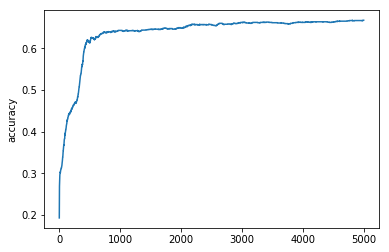

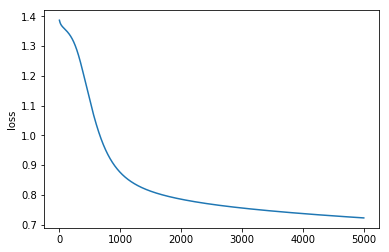

Decision Boundary for hidden layer size 3. acc:  0.6674057649667405


In [24]:
nn_architcture = [
    {'input_dim': nn_input_dim, 'output_dim': 18, 'actFunc': 'tanh'},
    {'input_dim': 18, 'output_dim': 18, 'actFunc': 'tanh'},
#     {'input_dim': 20, 'output_dim': 20, 'actFunc': 'tanh'},
#     {'input_dim': 20, 'output_dim': 8, 'actFunc': 'tanh'},
    {'input_dim': 18, 'output_dim': nn_output_dim, 'actFunc': 'tanh'},
]

layers, cost_history,accuracy_history  = train(X_train, Y_train, nn_architcture, epochs)
acc = get_acc(X_test, layers)
# plot_decision_boundary(lambda x: predict(x, layers))
# plt.title("Decision Boundary for hidden layer size 3")
print("Decision Boundary for hidden layer size 3. acc: ", acc)

w: (100, 20)
b: (1, 20)
w: (20, 16)
b: (1, 16)
w: (16, 20)
b: (1, 20)
w: (20, 4)
b: (1, 4)
random_idx:  [ 8 13]
random_idx:  [14  8 13  2  3]
||best_acc =>  0.402069475240207 ||cost =>  1.373858452309147 ||acc =>  0.402069475240207
||best_acc =>  0.631189948263119 ||cost =>  0.9060958969809635 ||acc =>  0.6289726533628973
||best_acc =>  0.6504065040650406 ||cost =>  0.7975680570350028 ||acc =>  0.6489283074648928
||best_acc =>  0.6504065040650406 ||cost =>  0.767241851640575 ||acc =>  0.6496674057649667
||best_acc =>  0.6518847006651884 ||cost =>  0.7515550197305192 ||acc =>  0.647450110864745
||best_acc =>  0.6577974870657798 ||cost =>  0.7405938411536228 ||acc =>  0.6577974870657798
||best_acc =>  0.6577974870657798 ||cost =>  0.7311976110866181 ||acc =>  0.6541019955654102
||best_acc =>  0.6592756836659276 ||cost =>  0.7221452153749188 ||acc =>  0.656319290465632
||best_acc =>  0.6592756836659276 ||cost =>  0.7191997316705802 ||acc =>  0.656319290465632
||best_acc =>  0.661492978566

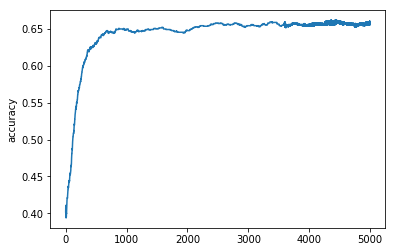

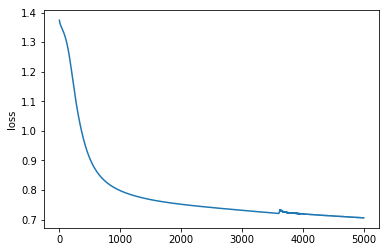

Decision Boundary for hidden layer size 4. acc:  0.6600147819660015


In [25]:
nn_architcture = [
    {'input_dim': nn_input_dim, 'output_dim': 20, 'actFunc': 'tanh'},
    {'input_dim': 20, 'output_dim': 16, 'actFunc': 'tanh'},
#     {'input_dim': 16, 'output_dim': 16, 'actFunc': 'tanh'},
    {'input_dim': 16, 'output_dim': 20, 'actFunc': 'tanh'},
    {'input_dim': 20, 'output_dim': nn_output_dim, 'actFunc': 'tanh'},
]

layers, cost_history,accuracy_history  = train(X_train, Y_train, nn_architcture, epochs)
acc = get_acc(X_test, layers)
# plot_decision_boundary(lambda x: predict(x, layers))
# plt.title("Decision Boundary for hidden layer size 4")
print("Decision Boundary for hidden layer size 4. acc: ", acc)

w: (100, 20)
b: (1, 20)
w: (20, 16)
b: (1, 16)
w: (16, 16)
b: (1, 16)
w: (16, 20)
b: (1, 20)
w: (20, 4)
b: (1, 4)
random_idx:  [ 8 13]
random_idx:  [14  8 13  2  3]
||best_acc =>  0.3074648928307465 ||cost =>  1.3903670628912848 ||acc =>  0.3074648928307465
||best_acc =>  0.6430155210643016 ||cost =>  0.8481860033764266 ||acc =>  0.6430155210643016
||best_acc =>  0.6541019955654102 ||cost =>  0.770474970600149 ||acc =>  0.6511456023651145
||best_acc =>  0.6541019955654102 ||cost =>  0.758224796119934 ||acc =>  0.6467110125646711
||best_acc =>  0.6541019955654102 ||cost =>  0.7485854439013807 ||acc =>  0.6518847006651884
||best_acc =>  0.6541019955654102 ||cost =>  0.7443301823985732 ||acc =>  0.6489283074648928
||best_acc =>  0.6541019955654102 ||cost =>  0.743793438623486 ||acc =>  0.6467110125646711
||best_acc =>  0.6541019955654102 ||cost =>  0.7352218749562311 ||acc =>  0.6459719142645972
||best_acc =>  0.6541019955654102 ||cost =>  0.737203539683252 ||acc =>  0.6481892091648189
||

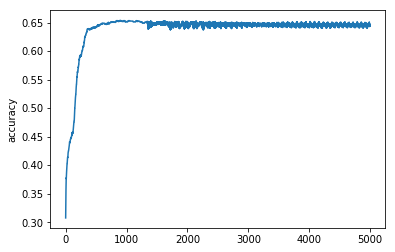

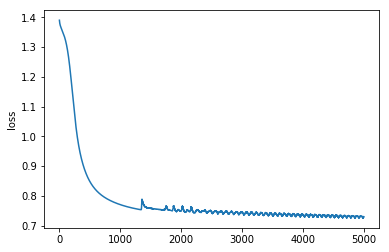

Decision Boundary for hidden layer size 4. acc:  0.6467110125646711


In [26]:
nn_architcture = [
    {'input_dim': nn_input_dim, 'output_dim': 20, 'actFunc': 'tanh'},
    {'input_dim': 20, 'output_dim': 16, 'actFunc': 'tanh'},
    {'input_dim': 16, 'output_dim': 16, 'actFunc': 'tanh'},
    {'input_dim': 16, 'output_dim': 20, 'actFunc': 'tanh'},
    {'input_dim': 20, 'output_dim': nn_output_dim, 'actFunc': 'tanh'},
]

layers, cost_history,accuracy_history  = train(X_train, Y_train, nn_architcture, epochs)
acc = get_acc(X_test, layers)
# plot_decision_boundary(lambda x: predict(x, layers))
# plt.title("Decision Boundary for hidden layer size 4")
print("Decision Boundary for hidden layer size 4. acc: ", acc)

In [ ]:
nn_architcture = [
    {'input_dim': nn_input_dim, 'output_dim': 90, 'actFunc': 'tanh'},
    {'input_dim': 90, 'output_dim': 80, 'actFunc': 'tanh'},
    {'input_dim': 80, 'output_dim': 70, 'actFunc': 'tanh'},
    {'input_dim': 70, 'output_dim': 60, 'actFunc': 'tanh'},
    {'input_dim': 60, 'output_dim': 50, 'actFunc': 'tanh'},
    {'input_dim': 50, 'output_dim': 25, 'actFunc': 'tanh'},
    {'input_dim': 25, 'output_dim': 15, 'actFunc': 'tanh'},
    {'input_dim': 15, 'output_dim': nn_output_dim, 'actFunc': 'tanh'},
]

layers, cost_history,accuracy_history  = train(X_train, Y_train, nn_architcture, epochs)
acc = get_acc(X_test, layers)
# plot_decision_boundary(lambda x: predict(x, layers))
# plt.title("Decision Boundary for hidden layer size 4")
print("Decision Boundary for hidden layer size 8. acc: ", acc)

w: (100, 90)
b: (1, 90)
w: (90, 80)
b: (1, 80)
w: (80, 70)
b: (1, 70)
w: (70, 60)
b: (1, 60)
w: (60, 50)
b: (1, 50)
w: (50, 25)
b: (1, 25)
w: (25, 15)
b: (1, 15)
w: (15, 4)
b: (1, 4)
random_idx:  [23 59]
random_idx:  [ 2 62 35 67 46]
||best_acc =>  0.30376940133037694 ||cost =>  1.3814106662038745 ||acc =>  0.30376940133037694
||best_acc =>  0.6511456023651145 ||cost =>  0.8065159468691487 ||acc =>  0.6304508499630451
||best_acc =>  0.6555801921655581 ||cost =>  0.7752924059411035 ||acc =>  0.6452328159645233
||best_acc =>  0.6555801921655581 ||cost =>  0.769589210205776 ||acc =>  0.6385809312638581
||best_acc =>  0.6614929785661493 ||cost =>  0.7236142247405473 ||acc =>  0.6467110125646711
